## CF --> PyART grid --> IMERG grid

In [1]:
import numpy as np
import xarray as xr
import os, time, sys, gzip, shutil
from datetime import datetime
import pyart
import matplotlib.pyplot as plt

# ****************************************************************************************

def read_file(cf_dir):

    # Find .cf.gz files
    file_list = [f for f in os.listdir(cf_dir) if f.endswith('.cf.gz')]
    if not file_list:
        print("No CF files found in", cf_dir)
        return
        
    file_list.sort()

    return file_list

# ****************************************************************************************

def py_grid(cf_dir,file):

    # Grid data with pyART
    file_unzip = decompress_gz(cf_dir+file)
    radar = pyart.io.read(file_unzip,file_field_names=True)

    radar_lat = radar.latitude['data'][0]
    radar_lon = radar.longitude['data'][0]

    grid = pyart.map.grid_from_radars(radar, grid_shape=(2, 301, 301),
               grid_limits=((0.,1000,), (-150000., 150000.), (-150000, 150000.)),
               gridding_algo='map_gates_to_grid',weighting_function='Barnes2',
               copy_field_data=True, fields = ('CZ','DR','RH','RC','RP','DM'),)
    
    py_ds = grid.to_xarray() # Convert grid to xarray

    os.remove(file_unzip)  # Remove decompressed file
    
    return py_ds

# ***************************************************************************************

def get_datetime_from_filename(f):

    # Grab date and time from file name
    fb = os.path.basename(f).split('_')
    y = fb[1]
    m = fb[2]
    h = fb[3]
    year   = int(y[0:4])
    month  = int(m[0:2])
    day    = int(m[2:])
    hour   = int(h[0:2])
    minute = int(h[2:4])
    second = int(h[4:6])

    return datetime(year, month, day, hour, minute, second)

# ****************************************************************************************

def set_attributes(DS,syear,smonth,sday,shour,sminute,ssecond):

   # Add attributes to final output 
   DS.attrs['Author'] = "Jason Pippitt"

   DS.attrs["Description"] = "CASMB 0.1 deg resolution rain rates and counts"
   DS.attrs["Version"] = 'V2.0 Python GRID'
   DS.attrs["Release_Date"] = str(datetime.utcnow())
   DS.attrs["Time"] = "UTC"
   DS.attrs["Scan_Date_Time"] = syear + "-" + smonth + "-" + sday + "   " + shour + ":" + sminute + ":" + ssecond + " UTC"
   DS.attrs["Conventions"] = "CF-1.8"

   DS.Longitude.attrs["long_name"] = "Longitude of each 0.1 deg box center corresponding to GPM IMERG product"
   DS.Longitude.attrs["units"] = "degrees east"

   DS.Latitude.attrs["long_name"] = "Latitude of each 0.1 deg box center corresponding to GPM IMERG product"
   DS.Latitude.attrs["units"] = "degrees north"

   DS.Height.attrs["long_name"] = "Height of the CASMB data"
   DS.Height.attrs["units"] = "km"

   DS.Total_points.attrs["long_name"] = "Total number of 1km x 1km radar pixels within each 0.1 deg grid box"
   DS.Total_points.attrs["units"] = ""

   DS.Rain_points.attrs["long_name"] = "Total number of 1km x 1km rainy radar pixels (R > 0 mm/hr) within each 0.1 deg grid box"
   DS.Rain_points.attrs["units"] = ""

   DS.RC_rate_uncond.attrs["long_name"] = "Unconditional (R >= 0 mm/hr) mean rain rate within each 0.1 deg grid box"
   DS.RC_rate_uncond.attrs["units"] = "mm/hr"

   DS.RC_rate_cond.attrs["long_name"] = "Conditional (R>0 mm/hr) mean rain rate within each 0.1 deg grid box"
   DS.RC_rate_cond.attrs["units"] = "mm/hr"

   return DS

# ****************************************************************************************

def get_deg_grids(dx, dy, dz, nx, ny, nz, center_lat, center_lon):
    
    """
    Generate xgrid, ygrid, and zgrid based on the given parameters.
    
    Args:
        dx, dy, dz: Grid spacing in degrees or meters.
        nx, ny, nz: Number of grid points in x, y, and z directions.
        center_lat, center_lon: Latitude and longitude of the grid center.
        
    Returns:
        xgrid, ygrid, zgrid: Arrays representing the grid.
    """
    
    xgrid = np.zeros(nx)
    ygrid = np.zeros(ny)
    zgrid = np.zeros(nz)

    radfac = np.pi / 180.0
    k2d_lat = 1.0 / 111177.0
    k2d_lon = 1.0 / (111177.0 * np.cos(center_lat * radfac))

    # Generate xgrid and ygrid
    i = 0
    for ii in range(-11, 12):
        xgrid[i] = center_lon + ii * dx
        ygrid[i] = center_lat + ii * dy
        i += 1

    # Define zgrid with two heights
    if nz == 2:
        zgrid[0] = 0.0        # Surface (0m)
        zgrid[1] = 1000.0     # 1000m altitude
    else:
        zgrid = np.linspace(0, dz * (nz - 1), nz)  # Generic height levels

    return xgrid, ygrid, zgrid

# ****************************************************************************************

def decompress_gz(file_path):
    """ Decompress a .gz file and return the decompressed file path. """
    decompressed_file = file_path.replace(".gz", "")
    with gzip.open(file_path, 'rb') as f_in, open(decompressed_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
    return decompressed_file

# ****************************************************************************************

def write_nc(ds_out,out_dir,file):

    # Ensure output directory exists
    os.makedirs(out_dir, exist_ok=True)
    
    # Get datetime object from filename
    dt = get_datetime_from_filename(file)
    year   = dt.year   ; syear = str(year)
    month  = dt.month  ; smonth = str("{:02d}".format(month))
    day    = dt.day    ; sday = str("{:02d}".format(day))
    hour   = dt.hour   ; shour = str("{:02d}".format(hour))
    minute = dt.minute ; sminute = str("{:02d}".format(minute))
    second = dt.second ; ssecond = str("{:02d}".format(second))

    # Generate output NetCDF filename
    fbase = os.path.basename(file)
    time_str = file.split('_')[3].split('.')[0]
    out_filename = f"{out_dir}{fbase.split('_')[0]}_{fbase.split('_')[1]}{fbase.split('_')[2]}_{time_str}_IMERG_GRID.nc"

    print("Saving IMERG grid:", out_filename)

    # Set attributes within file
    ds_out = set_attributes(ds_out,syear,smonth,sday,shour,sminute,ssecond)
        
    ds_out.to_netcdf(out_filename)
    ds_out.close()

# ****************************************************************************************

def process_radar_to_imerg_grid(py_ds, center_lat, center_lon):
    
    """ Processes radar pyART GRID and maps them to the IMERG-aligned 0.1° grid. """

    # Define IMERG 0.1° grid
    dx, dy, dz = 0.1, 0.1, 1
    nx, ny, nz = 23, 23, 2
    xgrid, ygrid, zgrid = get_deg_grids(dx, dy, dz, nx, ny, nz, center_lat, center_lon)

    # Extract radar grid lat/lon
    lon_data = py_ds["lon"].values
    lat_data = py_ds["lat"].values

    # Initialize mapping arrays
    point_label = np.full((2, 301, 301), -99, dtype=int)
    rc_1d, pt_1d, ht_1d = [], [], []  # Store rain rates, grid indices, and height levels

    # Initialize statistics arrays
    total_points = np.zeros((2, 23, 23), dtype=int)
    rain_points = np.zeros((2, 23, 23), dtype=int)
    rc_uncond_mean = np.zeros((2, 23, 23), dtype=float)
    rc_cond_mean = np.zeros((2, 23, 23), dtype=float)

    # Map radar points to 0.1° grid
    for k in range(2):
        rc_data = py_ds["RC"].isel(time=0, z=k).values  # Extract rain rates for this height

        for i in range(301):
            for j in range(301):
                my_lon, my_lat = lon_data[i, j], lat_data[i, j]
                diff_lon, diff_lat = np.abs(xgrid - my_lon), np.abs(ygrid - my_lat)

                if np.min(diff_lon) > 0.05 or np.min(diff_lat) > 0.05:
                    point_label[k, i, j] = -99  # Outside grid
                else:
                    xposn, yposn = np.argmin(diff_lon), np.argmin(diff_lat)
                    point_label[k, i, j] = xposn + (yposn * 23)

                    # Append to lists
                    pt_1d.append(point_label[k, i, j])
                    rc_1d.append(rc_data[i, j])
                    ht_1d.append(k)

    # Convert lists to NumPy arrays after the loop
    pt_1d = np.array(pt_1d)
    rc_1d = np.array(rc_1d)
    ht_1d = np.array(ht_1d)

    # Loop over height levels (z)
    for iz in range(2):  # 0 = surface, 1 = 1000m
        for ibox in range(23 * 23):  # 529 total boxes
            indices = np.where((pt_1d == ibox) & (ht_1d == iz))[0]  # Find points in this box at height z
            total_points[iz].flat[ibox] = len(indices)

            if len(indices) == 0: # No points in this box
                rc_uncond_mean[iz].flat[ibox] = 0.0
                rc_cond_mean[iz].flat[ibox] = 0.0
            else:
                box_data = rc_1d[indices]  # Get rain rate data for this box at height z
                valid = box_data[box_data > 0]  # Filter for rainy pixels
                rain_points[iz].flat[ibox] = len(valid) # Get rainy points
                box_data[box_data < 0] = 0.0 # Replace negative values with 0 for unconditional mean
                unvalid = box_data[box_data >= 0]  # Filter for pixels >= 0

                # Get Conditional Mean for pixels > 0
                if len(valid) != 0:
                    rc_cond_mean[iz].flat[ibox] = np.nanmean(valid)

                # Get UnConditional Mean for pixels >= 0
                if len(unvalid) != 0:
                    rc_uncond_mean[iz].flat[ibox] = np.nanmean(unvalid)

    # Create xarray dataset
    ds_out = xr.Dataset(
        {
            "Longitude": (["lon_elements"], xgrid),
            "Latitude": (["lat_elements"], ygrid),
            "Height": (["ht_elements"], zgrid),
            "Total_points": (["ht_elements", "lat_elements", "lon_elements"], total_points),
            "Rain_points": (["ht_elements", "lat_elements", "lon_elements"], rain_points),
            "RC_rate_uncond": (["ht_elements", "lat_elements", "lon_elements"], rc_uncond_mean),
            "RC_rate_cond": (["ht_elements", "lat_elements", "lon_elements"], rc_cond_mean),
        },
    )

    return ds_out

# *******************************************  M  A  I  N  **************************************************

if __name__ == '__main__':

    beg_time = time.perf_counter()

    '''
    if len(sys.argv) < 5:
        sys.exit('Usage: get_IMERG_grid.py SITE MM DD YYYY')
        
    site = sys.argv[1]
    mm = sys.argv[2].zfill(2)
    dd = sys.argv[3].zfill(2)
    yyyy = sys.argv[4].zfill(4)
    sy = yyyy[2:4]

    base_dir = f"/big_raid/Canada/{site}/"
    cf_dir = f"{base_dir}/products/cf/{mm}-{yyyy}/{sy}{mm}{dd}/"
    out_dir = f"{base_dir}/GRID/V2.0/{yyyy}/{mm}/"
    '''

    # Notebook testing remove in script
    site = 'CASMB'
    #cf_dir = "/Users/jpippitt/GPM-GV/CASMB/products/cf/05-2024/240515/temp/"
    cf_dir = '/Users/jpippitt/GPM-GV/CASMB/products/cf/07-2024/240726/temp/'
    out_dir = "/Users/jpippitt/GPM-GV/CASMB/IMERG/240726/"
    # Remove above for script

    # Set IMERG center, from J Wang.
    if site == 'CASMB': center_lat, center_lon = 45.95, -60.25  # CASMB center
    if site == 'KPOL':  center_lat, center_lon = 8.75, 167.75 # KPOL center
    if site == 'NPOL':  center_lat, center_lon = 38.25, -75.35 # NPOL center

    # Get File List
    file_list = read_file(cf_dir)

    # Loop through files
    for file in file_list:
        print('Reading the cfradial input file: ' + file, sep='\n')
        # Create pyART GRID
        py_ds = py_grid(cf_dir,file)
        # Convert to IMERG GRID
        ds_out = process_radar_to_imerg_grid(py_ds, center_lat, center_lon)
        # Write IMERG GRID out to .nc file
        write_nc(ds_out,out_dir,file)

    end_time = time.perf_counter()
    print(f'Run time was {round(((end_time-beg_time)/60), 1)} minute(s)')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Reading the cfradial input file: CASMB_2024_0726_092922.cf.gz
Saving IMERG grid: /Users/jpippitt/GPM-GV/CASMB/IMERG/240726/CASMB_20240726_092922_IMERG_GRID.nc
Run time was 0.1 minute(s)


### Open python and IDL output

In [2]:
# python IMERG grid file
#ds_py = xr.open_dataset("/Users/jpippitt/GPM-GV/CASMB/IMERG/240515/CASMB_20240515_021122_IMERG_GRID.nc")
ds_py = xr.open_dataset("/Users/jpippitt/GPM-GV/CASMB/IMERG/240726/CASMB_20240726_092922_IMERG_GRID.nc")

# IDL IMERG grid file
#idl_file = '/Users/jpippitt/GPM-GV/CASMB/raw/240515/CASMB_20240515_021122_IMERG_GRID_V1.0.nc'
idl_file = '/Users/jpippitt/GPM-GV/CASMB/raw/240726/old/CASMB_20240726_092922_IMERG_GRID_V1.0.nc'
ds_idl = xr.open_dataset(idl_file)

### Plot python vs. IDL

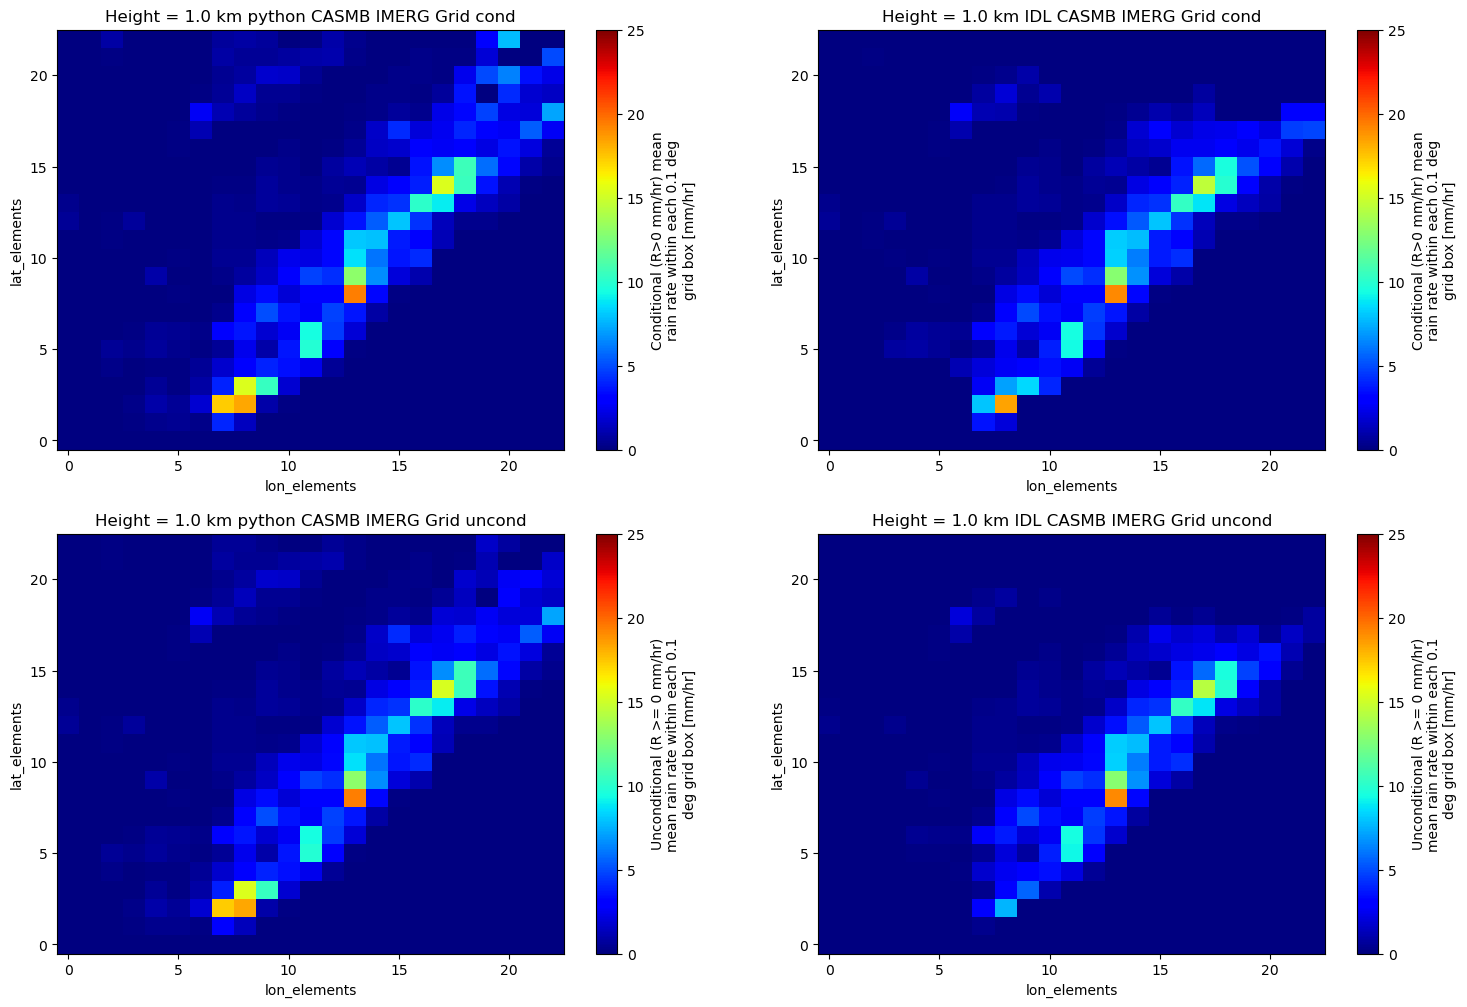

In [3]:
# Setup Plot
fig, axs = plt.subplots(figsize=(18, 12), nrows=2, ncols=2)

# Select Height 0 = surface, 1 = 1000m
z = 1
plot_height = (ds_py['Height'][z].values)/1000

# Plot RC
ds_py.RC_rate_cond[z].plot(x="lon_elements", cmap="jet", vmin=0, vmax=25, ax=axs[0, 0])
axs[0, 0].set_title(f'Height = {plot_height} km python CASMB IMERG Grid cond')
ds_idl.RC_rate_cond.plot(x="lon_elements", cmap="jet", vmin=0, vmax=25, ax=axs[0, 1])
axs[0, 1].set_title(f'Height = 1.0 km IDL CASMB IMERG Grid cond')
ds_py.RC_rate_uncond[z].plot(x="lon_elements", cmap="jet", vmin=0, vmax=25, ax=axs[1, 0])
axs[1, 0].set_title(f'Height = {plot_height} km python CASMB IMERG Grid uncond')
ds_idl.RC_rate_uncond.plot(x="lon_elements", cmap="jet", vmin=0, vmax=25, ax=axs[1, 1])
axs[1, 1].set_title(f'Height = 1.0 km IDL CASMB IMERG Grid uncond')

plt.show()

### Compare z=0 and z=1

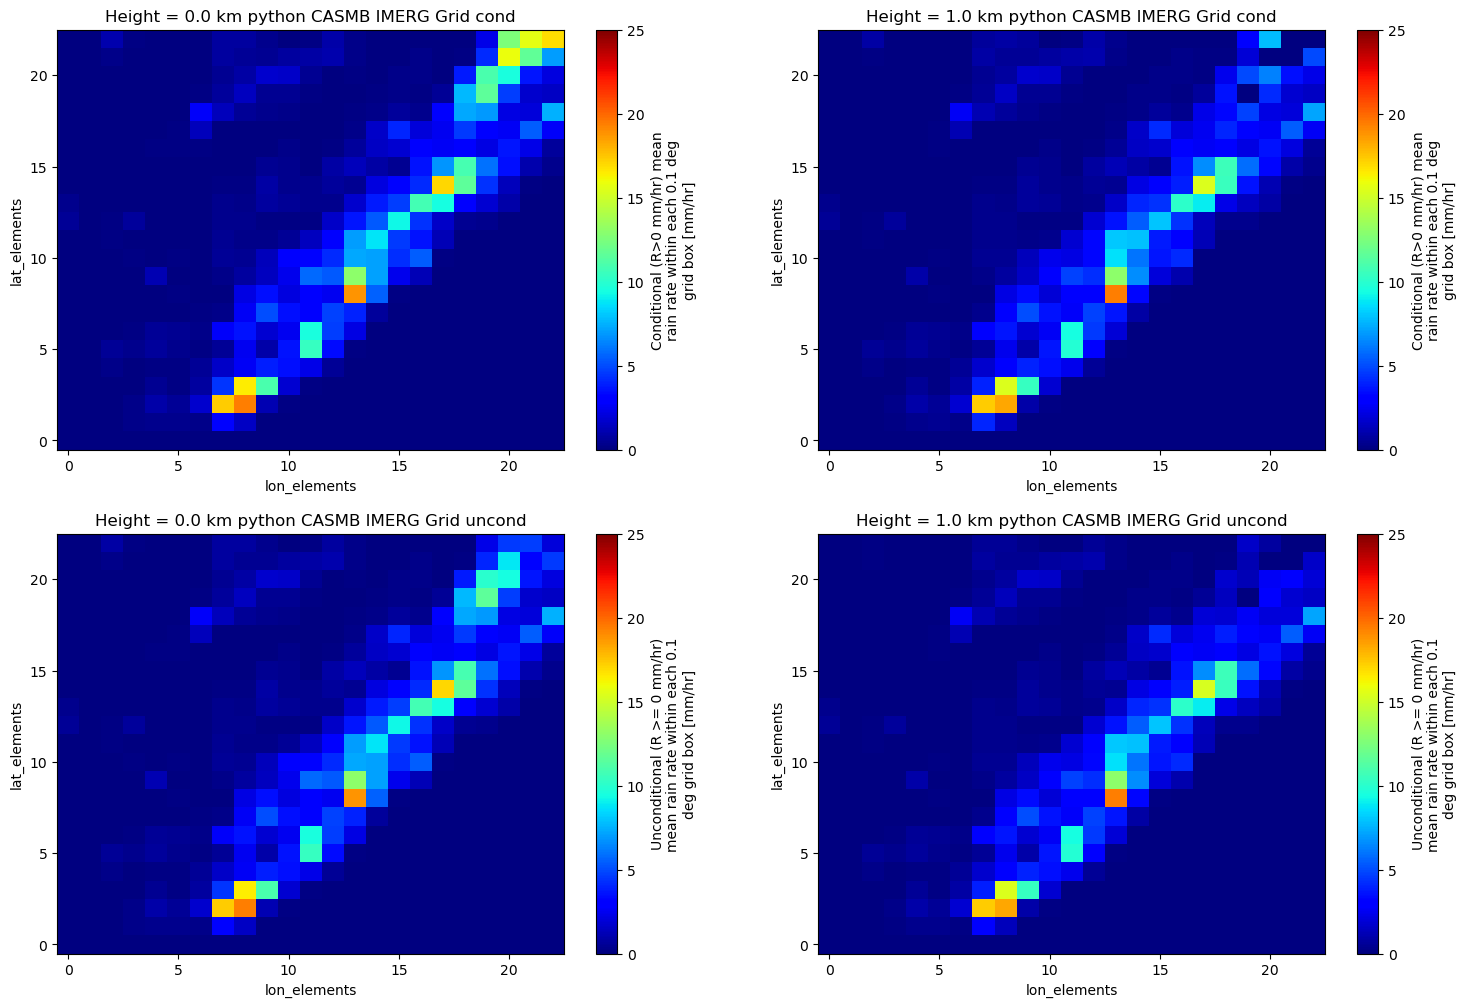

In [5]:
fig, axs = plt.subplots(figsize=(18, 12), nrows=2, ncols=2)

# Select Height 0 = surface, 1 = 1000m
plot_height_1 = (ds_py['Height'][1].values)/1000
plot_height_0 = (ds_py['Height'][0].values)/1000

# Plot RC
ds_py.RC_rate_cond[0].plot(x="lon_elements", cmap="jet", vmin=0, vmax=25, ax=axs[0, 0])
axs[0, 0].set_title(f'Height = {plot_height_0} km python CASMB IMERG Grid cond')
ds_py.RC_rate_cond[1].plot(x="lon_elements", cmap="jet", vmin=0, vmax=25, ax=axs[0, 1])
axs[0, 1].set_title(f'Height = {plot_height_1} km python CASMB IMERG Grid cond')
ds_py.RC_rate_uncond[0].plot(x="lon_elements", cmap="jet", vmin=0, vmax=25, ax=axs[1, 0])
axs[1, 0].set_title(f'Height = {plot_height_0} km python CASMB IMERG Grid uncond')
ds_py.RC_rate_uncond[1].plot(x="lon_elements", cmap="jet", vmin=0, vmax=25, ax=axs[1, 1])
axs[1, 1].set_title(f'Height = {plot_height_1} km python CASMB IMERG Grid uncond')

plt.show()

### Compare CASMB and IMERG-FR Precipitation

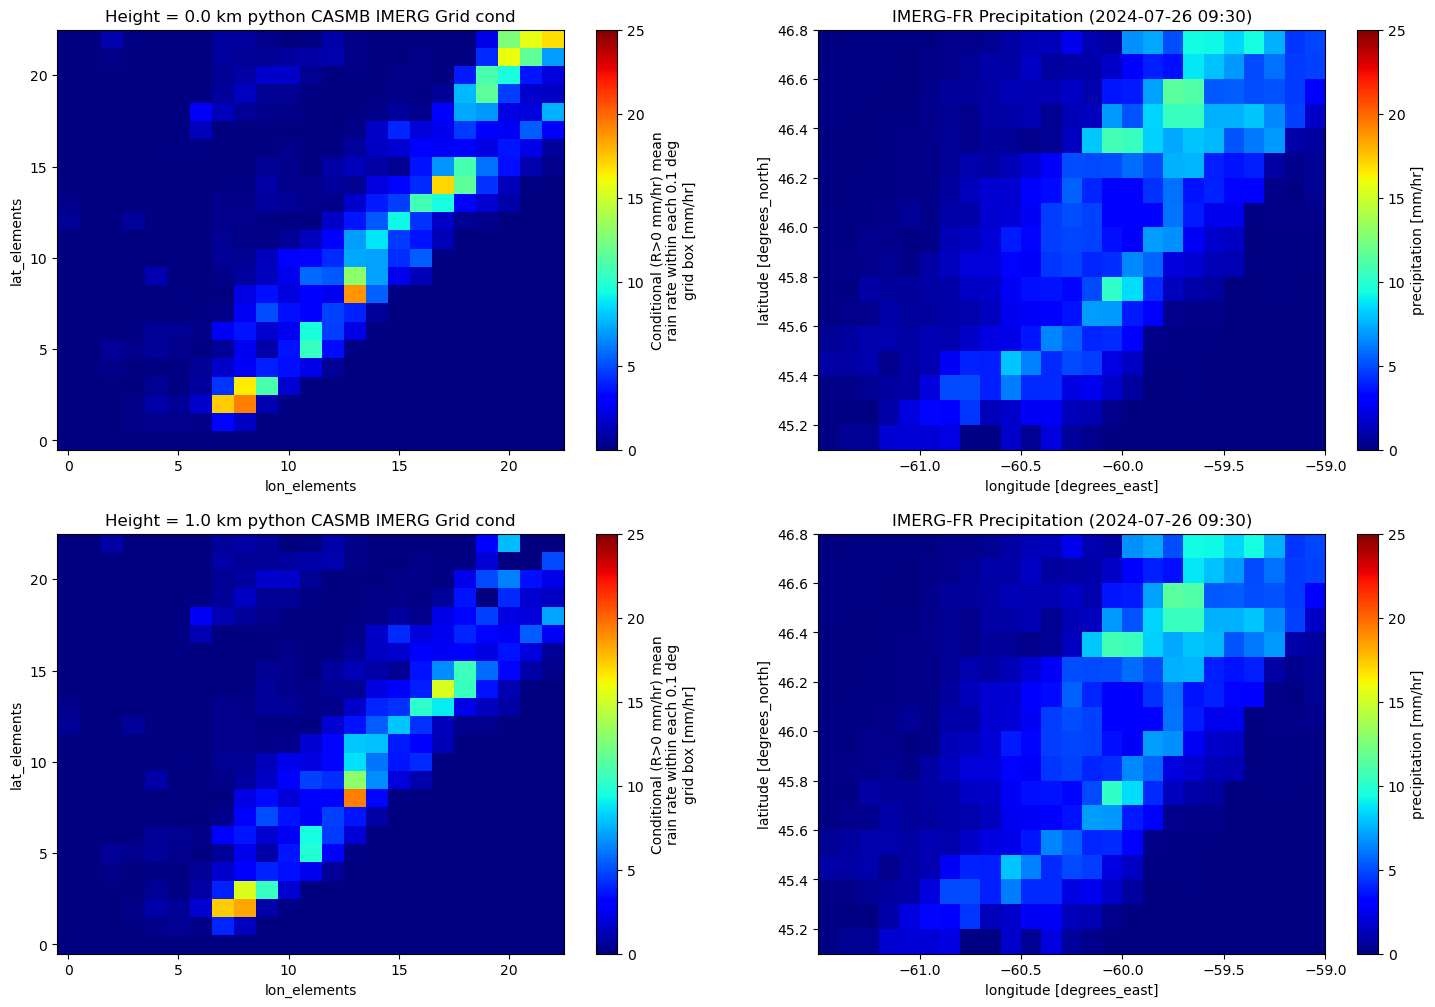

In [11]:
fig, axs = plt.subplots(figsize=(18, 12), nrows=2, ncols=2)

ds_py.RC_rate_cond[0].plot(x="lon_elements", cmap="jet", vmin=0, vmax=25, ax=axs[0, 0])
axs[0, 0].set_title(f'Height = {plot_height_0} km python CASMB IMERG Grid cond')
da_subset.plot(x="lon", cmap="jet", vmin=0, vmax=25, ax=axs[0, 1])
axs[0, 1].set_title(da_subset.gpm.title(add_timestep=True))
ds_py.RC_rate_cond[1].plot(x="lon_elements", cmap="jet", vmin=0, vmax=25, ax=axs[1, 0])
axs[1, 0].set_title(f'Height = {plot_height_1} km python CASMB IMERG Grid cond')
da_subset.plot(x="lon", cmap="jet", vmin=0, vmax=25, ax=axs[1, 1])
axs[1, 1].set_title(da_subset.gpm.title(add_timestep=True))

plt.show()

### Compare structures of new and old IMERG radar GRID files

In [12]:
ds_py

<xarray.Dataset> Size: 34kB
Dimensions:         (lon_elements: 23, lat_elements: 23, ht_elements: 2)
Dimensions without coordinates: lon_elements, lat_elements, ht_elements
Data variables:
    Longitude       (lon_elements) float64 184B ...
    Latitude        (lat_elements) float64 184B ...
    Height          (ht_elements) float64 16B ...
    Total_points    (ht_elements, lat_elements, lon_elements) int64 8kB ...
    Rain_points     (ht_elements, lat_elements, lon_elements) int64 8kB ...
    RC_rate_uncond  (ht_elements, lat_elements, lon_elements) float64 8kB ...
    RC_rate_cond    (ht_elements, lat_elements, lon_elements) float64 8kB ...
Attributes:
    Author:          Jason Pippitt
    Description:     CASMB 0.1 deg resolution rain rates and counts
    Version:         V2.0 Python GRID
    Release_Date:    2025-03-06 14:25:17.411288
    Time:            UTC
    Scan_Date_Time:  2024-07-26   09:29:22 UTC
    Conventions:     CF-1.8

In [13]:
ds_idl

<xarray.Dataset> Size: 9kB
Dimensions:         (lon_elements: 23, lat_elements: 23, ht_elements: 1)
Dimensions without coordinates: lon_elements, lat_elements, ht_elements
Data variables:
    Longitude       (lon_elements) float32 92B ...
    Latitude        (lat_elements) float32 92B ...
    Height          (ht_elements) float32 4B ...
    Total_points    (lat_elements, lon_elements) int32 2kB ...
    Rain_points     (lat_elements, lon_elements) int32 2kB ...
    RC_rate_uncond  (lat_elements, lon_elements) float32 2kB ...
    RC_rate_cond    (lat_elements, lon_elements) float32 2kB ...
Attributes:
    Author:          Jason Pippitt
    Description:     CASMB 0.1 deg resolution rain rates and counts
    Version:         V1.0
    Release_Date:    2024-08-05 09:52:08.117717
    Time:            UTC
    Scan_Date_Time:  2024-07-26   09:29:22 UTC
    Conventions:     CF-1.8

In [16]:
np.nanmean(ds_py.RC_rate_cond[1])

np.float64(1.1349971055181693)

In [15]:
np.nanmean(ds_idl.RC_rate_cond)

np.float32(0.928394)

### Input IMERG data with GPM-API

In [6]:
import datetime

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

import gpm
from gpm.utils.geospatial import (
    get_circle_coordinates_around_point,
    get_country_extent,
)

# Specify the product and product type
product = "IMERG-FR"  # 'IMERG-ER' 'IMERG-LR'
product_type = "RS"  # "NRT"
storage = "PPS"
# Specify the version
version = 7

# Specify the time period you are interested in
start_time = datetime.datetime.strptime("2024-07-26 09:29:00", "%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.strptime("2024-07-26 09:29:00", "%Y-%m-%d %H:%M:%S")

# Download the data
gpm.download(
    product=product,
    product_type=product_type,
    version=version,
    start_time=start_time,
    end_time=end_time,
    storage=storage,
    force_download=False,
    verbose=True,
    progress_bar=True,
    check_integrity=False,
)

All the available GPM IMERG-FR product files are already on disk.


In [7]:
# Load IMERG dataset
ds = gpm.open_dataset(
    product=product,
    product_type=product_type,
    version=version,
    start_time=start_time,
    end_time=end_time,
)

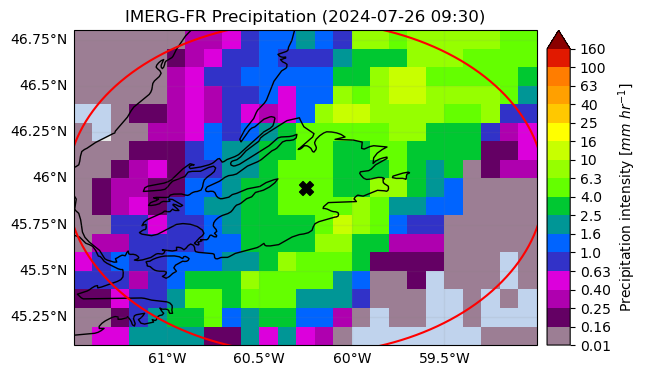

In [8]:
# Crop around a point (i.e. radar location)
lon = -60.25
lat = 45.95,
distance = 100_000
ds_subset = ds.gpm.crop_around_point(lon=lon, lat=lat, distance=distance)
da_subset = ds_subset['precipitation'].isel(time=0)
# Define ROI coordinates
circle_lons, circle_lats = get_circle_coordinates_around_point(
    lon,
    lat,
    radius=distance,
    num_vertices=360,
)

# Plot
p = da_subset.gpm.plot_map()
p.axes.set_title(da_subset.gpm.title(add_timestep=True))
p.axes.plot(circle_lons, circle_lats, "r-", transform=ccrs.Geodetic())
p.axes.scatter(lon, lat, c="black", marker="X", s=100, transform=ccrs.Geodetic())